In [18]:
import pickle
import os
import sympy as sp

# load the scenario-properties-baseline.pkl file
with open('../scenario-properties-baseline.pkl', 'rb') as f:
    scenario_properties = pickle.load(f)

In [19]:
scenario_properties.full_lambda

[[array([1.7999856, 1.7999856, 0.       , 0.       , 1.7999856, 0.       ,
         0.       , 3.5999712, 1.7999856, 0.       ]),
  array([0.       , 8.999928 , 0.       , 3.5999712, 0.       , 5.3999568,
         1.7999856, 3.5999712, 3.5999712, 0.       ]),
  array([7.19994240e+00, 1.79998560e+00, 1.73518612e+03, 1.74238606e+03,
         1.97818417e+03, 1.97818417e+03, 2.18698250e+03, 2.19958240e+03,
         2.41738066e+03, 2.40838073e+03]),
  array([46.7996256, 35.999712 , 34.1997264, 37.7996976, 41.3996688,
         57.5995392, 34.1997264, 26.999784 , 48.5996112, 25.1997984]),
  array([1330.18935849, 1299.58960328, 1812.58549932, 1810.78551372,
         1960.18431853, 1927.78457772, 2152.78277774, 2127.58297934,
         2442.58045936, 2465.98027216]),
  array([500.39599683, 493.19605443, 588.59529124, 602.99517604,
         660.59471524, 660.59471524, 710.99431205, 718.19425445,
         718.19425445, 757.79393765]),
  array([129.59896321, 125.99899201, 142.19886241, 142.19886241

In [2]:
equations_flattened = [scenario_properties.full_coll[i, j] for j in range(scenario_properties.full_coll.cols) for i in range(scenario_properties.full_coll.rows)]
equations = [sp.lambdify(scenario_properties.all_symbolic_vars, eq, 'numpy') for eq in equations_flattened]

In [3]:
x0 = scenario_properties.x0.T.values.flatten()

In [9]:
import numpy as np
# pass the x0 values to the equations
values = [eq(*x0) for eq in equations]

# create a matrix, each column has the next 40 items of values
values 

values = [values[i:i+10] for i in range(0, len(values), 10)]

su_only = values[1]

collision_probability = 1 - np.exp(su_only)

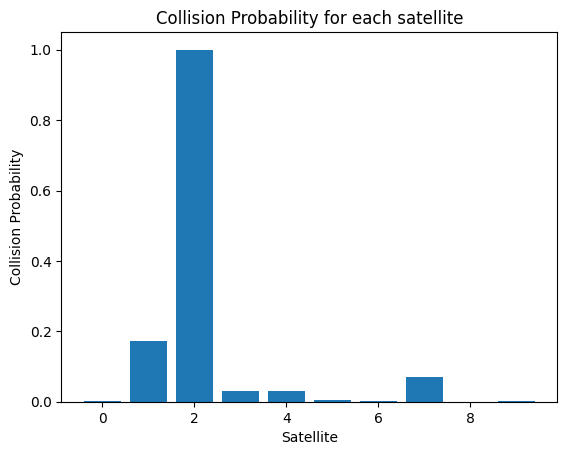

In [12]:
# create a bar chart of collision probability
import matplotlib.pyplot as plt

plt.bar(range(len(collision_probability)), collision_probability)
plt.xlabel('Satellite')
plt.ylabel('Collision Probability')
plt.title('Collision Probability for each satellite')
plt.show()